In [1]:
import sys
import random
import numpy as np
import os
from PIL import Image
import json
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from src.env.env import RILAB_OMY_ENV
from src.mujoco_helper.transforms import rpy2r, r2rpy
import torch
from src.dataset.utils import *
from src.mujoco_helper import MuJoCoParserClass

# Load the original dataset from teleoperations
dataset = LeRobotDataset('Jeongeun/deep_learning_2025',root = './dataset/demo_data')
metadata = dataset.meta

/home/rilab/ros2_ws/src/deep_learning_proj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Define the action and observation space for the environment
'''
action_type = 'delta_eef_pose'  # Options: 'joint','delta_joint, 'delta_eef_pose', 'eef_pose'
proprio_type = 'eef_pose' # Options: 'joint_pos', 'eef_pose'
observation_type = 'image' # options: 'image', 'object_pose'
image_aug_num = 2  # Number of augmented images to generate per original image
transformed_dataset_path = './dataset/transformed_data'

## Transform with the action space and agument image

In [3]:
'''
Create transformed dataset
'''
if os.path.exists(transformed_dataset_path):
    import shutil
    shutil.rmtree(transformed_dataset_path)
transformed_dataset = create_dataset(transformed_dataset_path, add_images = (observation_type=='image'))

In [4]:

'''
Load environment configuration and initialize environments
'''
config_file_path = './configs/train2.json'
with open(config_file_path) as f:
    env_conf = json.load(f)
omy_env = RILAB_OMY_ENV(cfg=env_conf, seed=0, 
                        action_type=action_type, 
                        obs_type=proprio_type,
                        vis_mode = 'teleop')
ik_env = MuJoCoParserClass(name='IK_env',rel_xml_path='./asset/scene_table.xml')


-----------------------------------------------------------------------------
name:[tabletop_env] dt:[0.002] HZ:[500]
 n_qpos:[34] n_qvel:[31] n_qacc:[31] n_ctrl:[8]
 integrator:[IMPLICITFAST]

n_body:[25]
 [0/25] [world] mass:[0.00]kg
 [1/25] [front_object_table] mass:[1.00]kg
 [2/25] [camera] mass:[0.00]kg
 [3/25] [camera2] mass:[0.00]kg
 [4/25] [camera3] mass:[0.00]kg
 [5/25] [base] mass:[3.59]kg
 [6/25] [link1] mass:[2.06]kg
 [7/25] [link2] mass:[3.68]kg
 [8/25] [link3] mass:[2.39]kg
 [9/25] [link4] mass:[1.40]kg
 [10/25] [link5] mass:[1.40]kg
 [11/25] [link6] mass:[0.65]kg
 [12/25] [camera_center] mass:[0.00]kg
 [13/25] [tcp_link] mass:[0.32]kg
 [14/25] [rh_p12_rn_r1] mass:[0.07]kg
 [15/25] [rh_p12_rn_r2] mass:[0.02]kg
 [16/25] [rh_p12_rn_l1] mass:[0.07]kg
 [17/25] [rh_p12_rn_l2] mass:[0.02]kg
 [18/25] [body_obj_wooden_cabinet] mass:[2.24]kg
 [19/25] [body_obj_wooden_cabinet_top] mass:[3.00]kg
 [20/25] [body_obj_wooden_cabinet_middle] mass:[3.00]kg
 [21/25] [body_obj_wooden_cabin

In [5]:

"""
Wraper function to iterate through episodes and apply image augmentation
"""
def iterate_episodes(dataset,transformed_dataset, omy_env, ik_env,q_init, start_idx_ori, end_idx_ori, language_instruction, img_aug = False):
    omy_env.reset()
    ik_env.reset()
    for _ in range(10):
        omy_env.action_type = 'joint'
        omy_env.step(q_init)
        omy_env.step_env()
    omy_env.action_type = action_type
    current_step = start_idx_ori
    if img_aug:
        omy_env.agument_object_random_color()
    while omy_env.env.is_viewer_alive():
        omy_env.step_env()
        if img_aug and omy_env.env.loop_every(HZ = 1):
            omy_env.agument_object_random_color()
        if omy_env.env.loop_every(HZ = 20):
            success = omy_env.check_success()
            if current_step > end_idx_ori - 1:
                break
            data = dataset.hf_dataset[current_step]
            if current_step == start_idx_ori:
                objet_info = parse_object_info(data)
                omy_env.set_object_pose(*objet_info)
            action = transform_action(data, omy_env, ik_env, action_type)
            observation = omy_env.step(action, gripper_mode='continuous')
            agent_image, wrist_image = omy_env.grab_image(return_side=False)
            # # resize to 256x256
            frame = {
                "state": observation,
                "action": action.astype(np.float32),
            }
            if observation_type == 'image':
                agent_image = Image.fromarray(agent_image)
                wrist_image = Image.fromarray(wrist_image)
                agent_image = agent_image.resize((256, 256))
                wrist_image = wrist_image.resize((256, 256))
                agent_image = np.array(agent_image)
                wrist_image = np.array(wrist_image)
                frame["image"] = agent_image
                frame["wrist_image"] = wrist_image
            else:
                obj_states, recp_q_poses = omy_env.get_object_pose(pad=10)
                frame['obj_pose'] = np.array(obj_states['poses'],dtype=np.float32),
                frame['obj_names'] = ','.join(obj_states['names'])
            transformed_dataset.add_frame(
                frame, task=language_instruction
            )
            omy_env.render()
            current_step += 1
    return success

In [ ]:
for episode_index in range(metadata.total_episodes):
        
    start_idx_ori = dataset.episode_data_index['from'][episode_index].item()
    end_idx_ori = dataset.episode_data_index['to'][episode_index].item()
    q_init = dataset.hf_dataset[start_idx_ori]['action'].numpy()
    language_instruction = dataset.hf_dataset[start_idx_ori]['task_index'].item()
    language_instruction = metadata.tasks[language_instruction]
    print(f"Episode {episode_index}, Instruction: {language_instruction}")
    success =   iterate_episodes(dataset, transformed_dataset, omy_env, ik_env, q_init, start_idx_ori, end_idx_ori, language_instruction)
    print(success)
    if success:
        transformed_dataset.save_episode()
    else:
        transformed_dataset.clear_episode_buffer()
    if observation_type == 'image':
        for _ in range(image_aug_num):
            # This will randomize object colors
            success =   iterate_episodes(dataset, transformed_dataset, omy_env, ik_env, q_init, start_idx_ori, end_idx_ori, language_instruction, img_aug=True)
            if success:
                transformed_dataset.save_episode()
            else:
                transformed_dataset.clear_episode_buffer()

Episode 0, Instruction: put block on the top drawer and close it
['top', 'close']
DONE INITIALIZATION
env:[IK_env] reset
True


Creating parquet from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 186.12ba/s]


['top', 'close']
DONE INITIALIZATION
env:[IK_env] reset


Creating parquet from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 205.51ba/s]


['top', 'close']
DONE INITIALIZATION
env:[IK_env] reset


Creating parquet from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 188.12ba/s]


Episode 1, Instruction: put block on the top drawer and close it
['top', 'close']
DONE INITIALIZATION
env:[IK_env] reset


## Check Augmented Dataset

In [ ]:
dataset = LeRobotDataset('transformed_data',transformed_dataset_path)

with open('configs/data.json') as f:
    configs = json.load(f)

omy_env = RILAB_OMY_ENV(configs, action_type=action_type, obs_type=proprio_type)

Generating train split: 1398 examples [00:00, 8780.69 examples/s]



-----------------------------------------------------------------------------
name:[tabletop_env] dt:[0.002] HZ:[500]
 n_qpos:[34] n_qvel:[31] n_qacc:[31] n_ctrl:[8]
 integrator:[IMPLICITFAST]

n_body:[25]
 [0/25] [world] mass:[0.00]kg
 [1/25] [front_object_table] mass:[1.00]kg
 [2/25] [camera] mass:[0.00]kg
 [3/25] [camera2] mass:[0.00]kg
 [4/25] [camera3] mass:[0.00]kg
 [5/25] [base] mass:[3.59]kg
 [6/25] [link1] mass:[2.06]kg
 [7/25] [link2] mass:[3.68]kg
 [8/25] [link3] mass:[2.39]kg
 [9/25] [link4] mass:[1.40]kg
 [10/25] [link5] mass:[1.40]kg
 [11/25] [link6] mass:[0.65]kg
 [12/25] [camera_center] mass:[0.00]kg
 [13/25] [tcp_link] mass:[0.32]kg
 [14/25] [rh_p12_rn_r1] mass:[0.07]kg
 [15/25] [rh_p12_rn_r2] mass:[0.02]kg
 [16/25] [rh_p12_rn_l1] mass:[0.07]kg
 [17/25] [rh_p12_rn_l2] mass:[0.02]kg
 [18/25] [body_obj_wooden_cabinet] mass:[2.24]kg
 [19/25] [body_obj_wooden_cabinet_top] mass:[3.00]kg
 [20/25] [body_obj_wooden_cabinet_middle] mass:[3.00]kg
 [21/25] [body_obj_wooden_cabin

In [ ]:

class EpisodeSampler(torch.utils.data.Sampler):
    """
    Sampler for a single episode
    """
    def __init__(self, dataset: LeRobotDataset, episode_index: int):
        from_idx = dataset.episode_data_index["from"][episode_index].item()
        to_idx = dataset.episode_data_index["to"][episode_index].item()
        self.frame_ids = range(from_idx, to_idx)

    def __iter__(self):
        return iter(self.frame_ids)

    def __len__(self) -> int:
        return len(self.frame_ids)

In [ ]:
episode_index =0

episode_sampler = EpisodeSampler(dataset, episode_index)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,
    batch_size=1,
    sampler=episode_sampler,
)


In [ ]:
step = 0
iter_dataloader = iter(dataloader)
omy_env.reset()
clips = []
actions = []
save_flag = True

while omy_env.env.is_viewer_alive():
    # PnPEnv.forward_env(action)
    omy_env.step_env()
    # if omy_env.env.loop_every(HZ = 1):
    #     omy_env.agument_object_random_color()
    if omy_env.env.loop_every(HZ=20):
        # Get the action from dataset
        data = next(iter_dataloader)
        language_instruction = data['task'][0]
        # Get the action from dataset
        action = data['action'].numpy()
        # print(action.shape)
        if 'image' in data.keys():
            img = data['image'][0].numpy()*255
            img =  np.transpose(img, (1,2,0))
            if save_flag:
                clips.append(img.astype(np.uint8))
                actions.append(action[0])
            # print(action.shape)
            # obs = PnPEnv.step(state[0])
            # Visualize the image from dataset to rgb_overlay
            omy_env.rgb_agent = data['image'][0].numpy()*255
            omy_env.rgb_ego = data['wrist_image'][0].numpy()*255
            omy_env.rgb_agent = omy_env.rgb_agent.astype(np.uint8)
            omy_env.rgb_ego = omy_env.rgb_ego.astype(np.uint8)
            # 3 256 256 -> 256 256 3
            omy_env.rgb_agent = np.transpose(omy_env.rgb_agent, (1,2,0))
            omy_env.rgb_ego = np.transpose(omy_env.rgb_ego, (1,2,0))
            omy_env.rgb_side = np.zeros((480, 640, 3), dtype=np.uint8)
        omy_env.render(language_instruction)
        step += 1
        omy_env.step(action[0], gripper_mode='continuous')
        if step == len(episode_sampler):
            # start from the beginning
            iter_dataloader = iter(dataloader)
            # omy_env.reset()
            step = 0
        if step == 0:
            omy_env.env.reset()
            omy_env.reset()
            save_flag = False
    omy_env.env.sync_sim_wall_time()

['top', 'close']
DONE INITIALIZATION
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 -0.11851542  1.18432506]
[ 0.19696709 

In [ ]:
actions = np.asarray(actions)

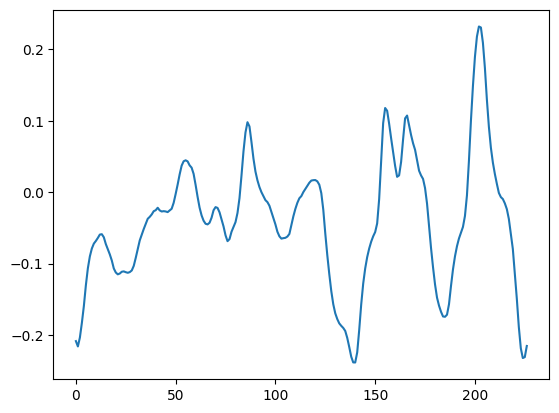

In [ ]:
import matplotlib.pyplot as plt
z = actions[:,2]
plt.plot(z)
plt.show()